In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

print(torch.__version__)
print(torch.cuda.is_available())

1.6.0
True


# 1. Dataset
- Fashion Mnist

#### Preview

In [2]:
%%capture
import torchvision

dataset = torchvision.datasets.FashionMNIST(root='/tmp/mnist', download=True)

Label: 9


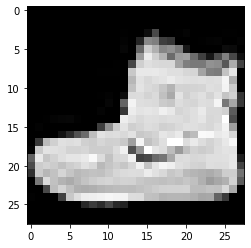

In [3]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

Label: 0


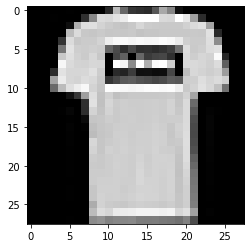

In [4]:
image, label = dataset[1]
plt.imshow(image, cmap='gray')
print('Label:', label)

## 1.1 Get dataset

In [5]:
%%capture
import torchvision
import torchvision.transforms as transforms

train_dataset = torchvision.datasets.FashionMNIST(
    root='/tmp/mnist',
    train=True,
    transform=transforms.ToTensor(),
    download=True)
test_dataset = torchvision.datasets.FashionMNIST(
    root='/tmp/mnist',
    train=False,
    transform=transforms.ToTensor(),
    download=True)

#### X

In [6]:
print(train_dataset.data.shape)
print(test_dataset.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [7]:
print(train_dataset.data.max())
print(test_dataset.data.min())

tensor(255, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)


#### y

In [8]:
print(train_dataset.targets.unique())

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [9]:
print(train_dataset.targets.shape)
print(test_dataset.targets.shape)

torch.Size([60000])
torch.Size([10000])


## 1.2 Dataloader

In [10]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=batch_size, 
    shuffle=False)

In [11]:
print(len(train_loader))
for Xb_train, yb_train in train_loader:
    print(Xb_train.shape, yb_train.shape)
    break

469
torch.Size([128, 1, 28, 28]) torch.Size([128])


# 2. Model

In [12]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()

        # Conv Layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
            nn.ReLU()
        )

        # Dense layer
        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(128 * 2 * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, K)
        )
    
    def forward(self, X):
        out = self.conv_layers(X)
        out = out.view(out.size(0), -1)
        out = self.dense_layers(out)
        return out

In [13]:
K = len(set(train_dataset.targets.numpy()))
print(f"Number of classes: {K}")

# Model
cnn_model = CNN(K)

# Loss 
ce_loss = nn.CrossEntropyLoss()

# optimizer
adam_opt = torch.optim.Adam(cnn_model.parameters())

Number of classes: 10


In [14]:
# Use GPU to train
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

cnn_model.to(device)

Using cuda:0


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

# 3. Train

In [15]:
def fit(train_loader, valid_loader, model, loss_fn, optimizer, n_epochs):
    train_losses = np.zeros(n_epochs)
    valid_losses = np.zeros(n_epochs)

    for i in range(n_epochs):
        # Train by batches
        train_batch_loss = []
        for X_b, y_b in train_loader:
            # Load data to GPU
            X_train, y_train = X_b.to(device), y_b.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            y_train_ = model(X_train)
            loss = loss_fn(y_train_, y_train)

            # Backward
            loss.backward()
            optimizer.step()

            train_batch_loss.append(loss.item())

        # Valid by batches
        valid_batch_loss = []
        for X_valid, y_valid in test_loader:
            # Load data to GPU
            X_valid, y_valid = X_valid.to(device), y_valid.to(device)

            # fit
            y_valid_ = model(X_valid)
            loss = loss_fn(y_valid_, y_valid)

            valid_batch_loss.append(loss.item())


        # Save losses
        train_loss = np.mean(train_batch_loss)
        valid_loss = np.mean(valid_batch_loss)
        train_losses[i] = train_loss
        valid_losses[i] = valid_loss
            
        if (i+1) % 2 == 0:
            print(f'Epoch {i+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

    # Plot
    plt.plot(train_losses, label='train loss')
    plt.plot(valid_losses, label='valid loss')
    plt.legend()
    plt.show()

Epoch 2/20, Train Loss: 0.4268, Valid Loss: 0.4068
Epoch 4/20, Train Loss: 0.3259, Valid Loss: 0.3526
Epoch 6/20, Train Loss: 0.2772, Valid Loss: 0.3123
Epoch 8/20, Train Loss: 0.2426, Valid Loss: 0.3005
Epoch 10/20, Train Loss: 0.2127, Valid Loss: 0.3249
Epoch 12/20, Train Loss: 0.1917, Valid Loss: 0.3018
Epoch 14/20, Train Loss: 0.1681, Valid Loss: 0.2971
Epoch 16/20, Train Loss: 0.1496, Valid Loss: 0.3167
Epoch 18/20, Train Loss: 0.1337, Valid Loss: 0.3374
Epoch 20/20, Train Loss: 0.1201, Valid Loss: 0.3533


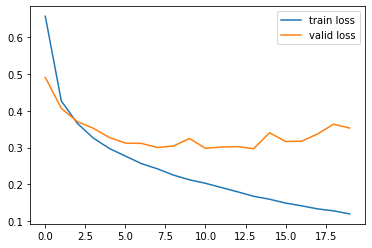

In [16]:
valid_loader = test_loader

fit(train_loader, valid_loader,
    model=cnn_model, loss_fn=ce_loss, optimizer=adam_opt,
    n_epochs=20)

# 4. Test

#### Accuracy

In [21]:
n_correct = 0.
n_total = 0.
for Xb_test, yb_test in test_loader:
    # Load data to GPU
    Xb_test, yb_test = Xb_test.to(device), yb_test.to(device)

    # Fit
    yb_test_ = cnn_model(Xb_test)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(yb_test_, 1)
  
    # update counts
    n_correct += (predictions == yb_test).sum().item()
    n_total += yb_test.shape[0]

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")

Test acc: 0.8939


#### Confusion matrix

In [22]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(
    cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Confusion matrix, without normalization
[[875   1  19  14   3   0  84   0   4   0]
 [  2 972   2  16   3   0   4   0   1   0]
 [ 18   0 839   5  62   0  75   0   1   0]
 [ 19   4  22 883  28   0  42   0   1   1]
 [  3   0  51  28 848   0  70   0   0   0]
 [  1   0   0   1   1 951   0  29   4  13]
 [123   1  52  16  87   0 714   0   7   0]
 [  0   0   0   0   0   4   0 956   0  40]
 [  7   0   8   1   7   1   5   5 966   0]
 [  1   0   0   0   0   6   0  38   0 955]]


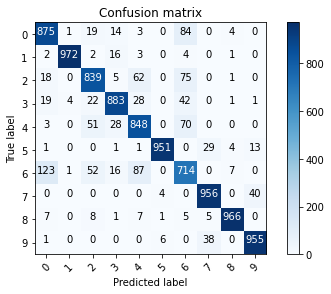

In [23]:
x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for Xb_test, yb_test in test_loader:
    # Load data to GPU
    Xb_test, yb_test = Xb_test.to(device), yb_test.to(device)

    # Fit
    yb_test_ = cnn_model(Xb_test)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(yb_test_, 1)
  
    # update p_test
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

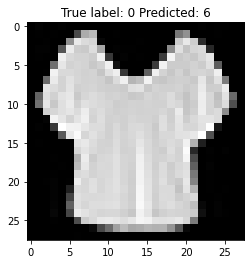

In [24]:
# Show some misclassified examples
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (y_test[i], int(p_test[i])));

# 5. Clear GPU

In [30]:
torch.cuda.empty_cache()